In [26]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import numpy as np
import cmocean as cm
import glob
from salishsea_tools import (
    viz_tools, geo_tools, nc_tools
)
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [28]:

thalweg_file='/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)


In [29]:
print(np.shape(thalweg_pts))
# print(np.shape(thalweg))

(1533, 2)


In [30]:
def make_nclen(start,end,ftype):
    base_ar = []
    sens_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    
    print('days: '+str(len(arrow_array)))
    dayslen = len(arrow_array)
    print(dayslen)
    hovmoller_base = np.zeros([1533,40,dayslen])
    hovmoller_sens = np.zeros([1533,40,dayslen])

    for i in range(0,dayslen):
        #print(i)
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        #nc_base = '/results2/SalishSea/hindcast.201812_annex/' + ddmmmyy +'/SalishSea_1d_*_' + ftype +'_T.nc'
        nc_base = '/data/tjarniko/results/FPARTY/fchlr/SKOG_1d_*'+ ftype +'_T_' + ymd + '-' + ymd + '.nc'
        nc_sens = '/data/tjarniko/results/RIVPARTY/SKOG_1d_*'+ ftype +'_T_' + ymd + '-' + ymd + '.nc'
        #nc_sens = '/results2/SalishSea/hindcast.201812_annex/' + ddmmmyy +'/SalishSea_1d_*_' + ftype +'_T.nc'
#         print(nc_sens)
        #print('ANALYZING ',ddmmmyy)
        
        tnc_base = glob.glob(nc_base) 
        tnc_sens = glob.glob(nc_sens)
    
        #print(tnc_base[0])
        base_ar.append(tnc_base[0])
        #print(tnc_sens[0]) 
        sens_ar.append(tnc_sens[0])
        
    return base_ar, sens_ar

In [31]:
start = '2018-05-02'
end = '2018-06-30'

base_ar, sens_ar = make_nclen(start,end,'carp')

base_arG,sens_arG = make_nclen(start,end,'grid')

days: 60
60
days: 60
60


In [32]:
def combine_files(files, var, jss, iss):

    time = np.array([])
    var_list = []
    i = 0
    for f in files:
        if i%10 == 0:
            print(i)
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:]
        var_tmp=var_tmp[:,:,jss,iss]
        
        var_list.append(var_tmp)
        t = nc_tools.timestamp(G, np.arange(var_tmp.shape[0]))
        try:
            for ind in range(len(t)):
                t[ind] = t[ind].datetime
        except TypeError:
            t = t.datetime
        time = np.append(time, t)
        i = i+1

    var_ary = np.concatenate(var_list, axis=0)
    return var_ary, time

In [33]:

dic_base = combine_files(base_ar,'dissolved_inorganic_carbon',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
dic_base2 = dic_base[0]
print(np.shape(dic_base2))

dic_sens = combine_files(sens_ar,'dissolved_inorganic_carbon',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
dic_sens2 = dic_sens[0]
print(np.shape(dic_sens2))

temp_base = combine_files(base_arG,'votemper',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
temp_base2 = temp_base[0]
print(np.shape(temp_base2))

temp_sens = combine_files(sens_arG,'votemper',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
temp_sens2 = temp_sens[0]
print(np.shape(temp_sens2))

sal_base = combine_files(base_arG,'vosaline',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
sal_base2 = sal_base[0]
print(np.shape(sal_base2))

sal_sens = combine_files(sens_arG,'vosaline',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
sal_sens2 = sal_sens[0]
print(np.shape(sal_sens2))

0
10
20
30
40
50
(60, 40, 1533)
0
10
20
30
40
50
(60, 40, 1533)
0
10
20
30
40
50
(60, 40, 1533)
0
10
20
30
40
50
(60, 40, 1533)
0
10
20
30
40
50
(60, 40, 1533)
0
10
20
30
40
50
(60, 40, 1533)


In [34]:
# %matplotlib inline

# ###figures
# fig = plt.figure(figsize=(10,5))

# for i in range(1,2):
#     if i == 1:
#         ax = fig.add_subplot(1,1,i)
#         tplt = dic_base2[:,10,:] - dic_sens2[:,10,:]
#         t_cmap = cm.cm.balance
#         mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-300, vmax=300)
#         ax.set_title('DIFFERENCE BASE-SENS Hovmoller plot of DIC along Salish Sea Thalweg,  \n 10M DEPTH, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

#         cbar = fig.colorbar(mesh, ax=ax)

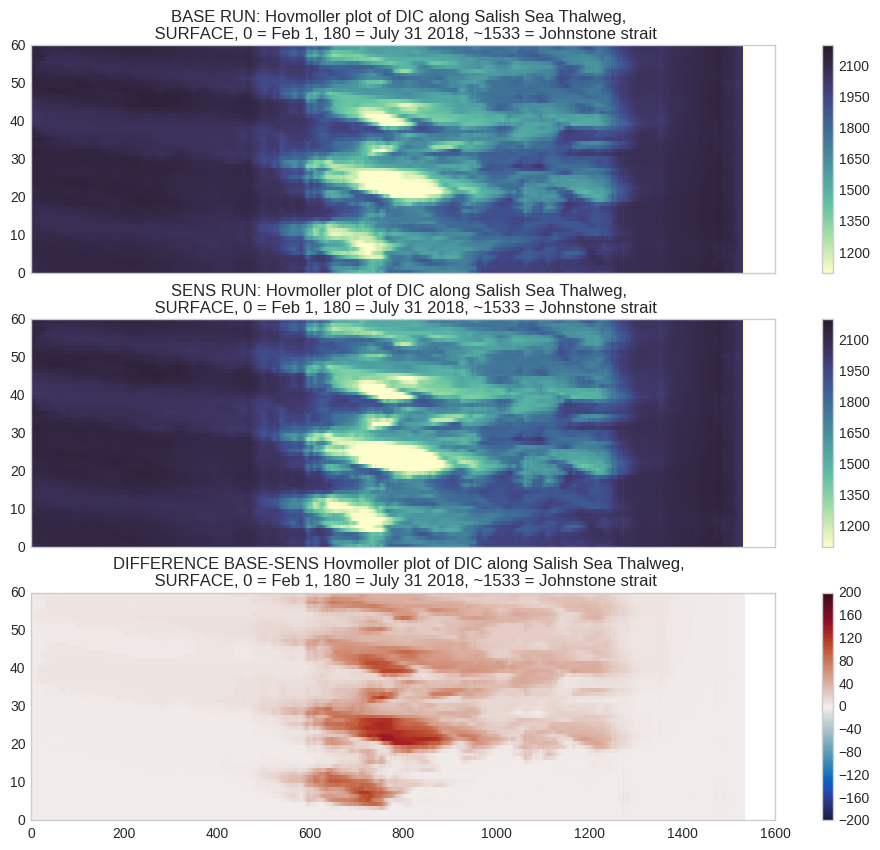

In [50]:
%matplotlib inline

###figures
fig = plt.figure(figsize=(12,10))

for i in range(1,4):
    if i == 1:
        ax = fig.add_subplot(3,1,i)
        tplt = dic_base2[:,0,:]
        t_cmap = cm.cm.deep
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=1100, vmax=2200)
        ax.set_title('BASE RUN: Hovmoller plot of DIC along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(3,1,i)
        tplt = dic_sens2[:,0,:]
        t_cmap = cm.cm.deep
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=1100, vmax=2200)
        ax.set_title('SENS RUN: Hovmoller plot of DIC along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(3,1,i)
        tplt = dic_base2[:,0,:] - dic_sens2[:,0,:]
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-200, vmax=200)
        ax.set_title('DIFFERENCE BASE-SENS Hovmoller plot of DIC along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

        cbar = fig.colorbar(mesh, ax=ax)

In [36]:
ta_base = combine_files(base_ar,'total_alkalinity',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
ta_base2 = ta_base[0]

ta_sens = combine_files(sens_ar,'total_alkalinity',thalweg_pts[:, 0],thalweg_pts[:, 1])
#extract masked array from tuple
ta_sens2 = ta_sens[0]


0
10
20
30
40
50
0
10
20
30
40
50


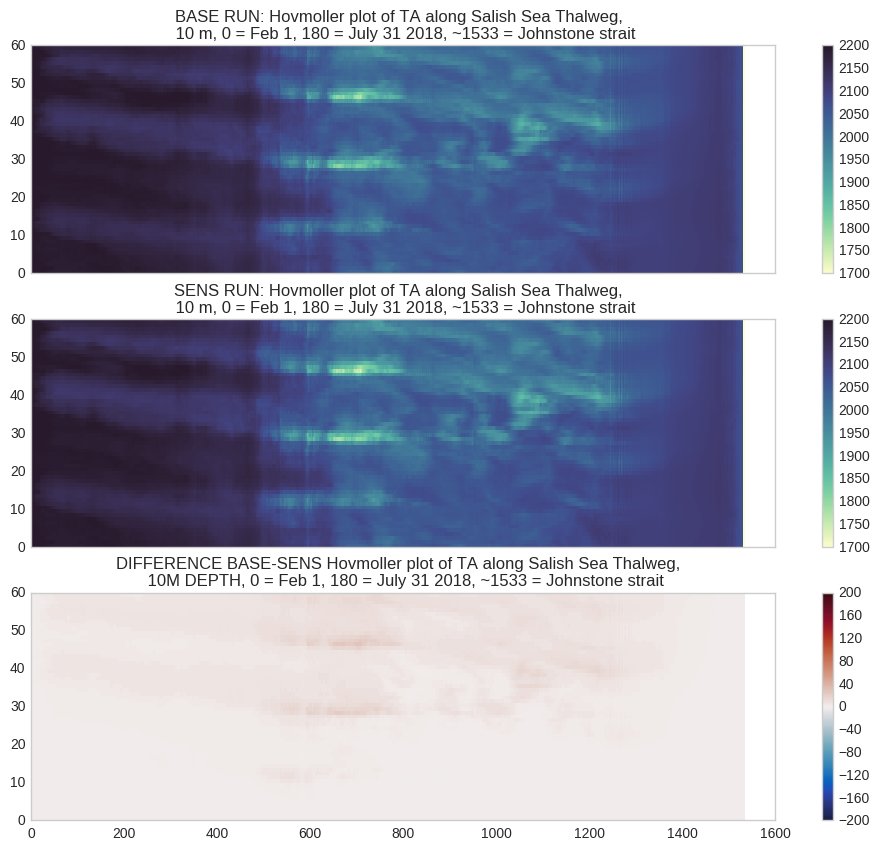

In [37]:
%matplotlib inline

###figures
fig = plt.figure(figsize=(12,10))

for i in range(1,4):
    if i == 1:
        ax = fig.add_subplot(3,1,i)
        tplt = ta_base2[:,10,:]
        t_cmap = cm.cm.deep
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=1700, vmax=2200)
        ax.set_title('BASE RUN: Hovmoller plot of TA along Salish Sea Thalweg,  \n 10 m, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(3,1,i)
        tplt = ta_sens2[:,10,:]
        t_cmap = cm.cm.deep
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=1700, vmax=2200)
        ax.set_title('SENS RUN: Hovmoller plot of TA along Salish Sea Thalweg,  \n 10 m, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(3,1,i)
        tplt = ta_base2[:,10,:] - ta_sens2[:,10,:]
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-200, vmax=200)
        ax.set_title('DIFFERENCE BASE-SENS Hovmoller plot of TA along Salish Sea Thalweg,  \n 10M DEPTH, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

        cbar = fig.colorbar(mesh, ax=ax)

0.00214529
-0.000229359


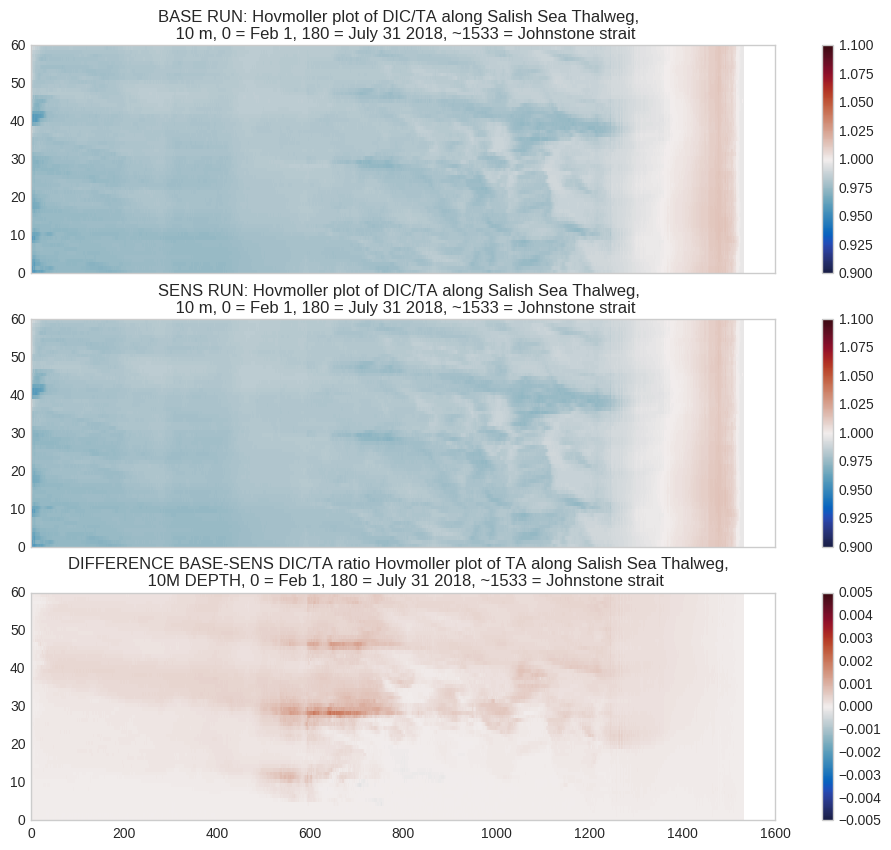

In [38]:
%matplotlib inline

###figures
fig = plt.figure(figsize=(12,10))

for i in range(1,4):
    if i == 1:
        ax = fig.add_subplot(3,1,i)
        tplt = dic_base2[:,10,:]/ta_base2[:,10,:]
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=0.9, vmax=1.1)
        ax.set_title('BASE RUN: Hovmoller plot of DIC/TA along Salish Sea Thalweg,  \n 10 m, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(3,1,i)
        tplt = dic_sens2[:,10,:]/ta_sens2[:,10,:]
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=0.9, vmax=1.1)
        ax.set_title('SENS RUN: Hovmoller plot of DIC/TA along Salish Sea Thalweg,  \n 10 m, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(3,1,i)
        tplt1 = dic_base2[:,10,:]/ta_base2[:,10,:]
        tplt2 = dic_sens2[:,10,:]/ta_sens2[:,10,:]
        tplt = tplt1-tplt2
        print(np.max(tplt))
        print(np.min(tplt))
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-0.005, vmax=0.005)
        ax.set_title('DIFFERENCE BASE-SENS DIC/TA ratio Hovmoller plot of TA along Salish Sea Thalweg,  \n 10M DEPTH, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

        cbar = fig.colorbar(mesh, ax=ax)

In [39]:
tdir = '/data/tjarniko/results/SAMPL/'
w = glob.glob(tdir + 'SalishSea_1ts_*carp*')
w2 = glob.glob(tdir + 'SalishSea_1ts_*grid_T*')
print(w[0])
carp = nc.Dataset(w[0])
grid = nc.Dataset(w2[0])

tsal = grid.variables['vosaline'][0,0,:,:]
ttemp = grid.variables['votemper'][0,0,:,:]
tdic = carp.variables['dissolved_inorganic_carbon'][0,0,:,:]
tta = carp.variables['total_alkalinity'][0,0,:,:]

print(grid.variables['deptht_bounds'][:])

/data/tjarniko/results/SAMPL/SalishSea_1ts_20141121_20141121_carp_T_20141121-20141121.nc
[[   0.            1.00000119]
 [   1.00000119    2.00000644]
 [   2.00000644    3.00001931]
 [   3.00001931    4.00004673]
 [   4.00004673    5.00010395]
 [   5.00010395    6.00021696]
 [   6.00021696    7.0004406 ]
 [   7.0004406     8.00087929]
 [   8.00087929    9.00173569]
 [   9.00173569   10.00340652]
 [  10.00340652   11.00666237]
 [  11.00666237   12.01300812]
 [  12.01300812   13.02536583]
 [  13.02536583   14.04942894]
 [  14.04942894   15.0962553 ]
 [  15.0962553    16.18730354]
 [  16.18730354   17.36403465]
 [  17.36403465   18.70597267]
 [  18.70597267   20.36347389]
 [  20.36347389   22.61306381]
 [  22.61306381   25.93741226]
 [  25.93741226   31.10103416]
 [  31.10103416   39.11885834]
 [  39.11885834   50.96323776]
 [  50.96323776   67.05207062]
 [  67.05207062   86.96746826]
 [  86.96746826  109.73706818]
 [ 109.73706818  134.34593201]
 [ 134.34593201  160.02955627]
 [ 160.02955

In [40]:
size_box = np.shape(tdic)
size_0 = size_box[0]
size_1= size_box[1]
print(size_1)

398


In [41]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    
#     tsal = grid.variables['vosaline'][0,0,:,:]
#     ttemp = grid.variables['votemper'][0,0,:,:]
#     tdic = carp.variables['dissolved_inorganic_carbon'][0,0,:,:]
#     tta = carp.variables['total_alkalinity'][0,0,:,:]

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth[:] = depth_this
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1)
    OmAr = OmegaA.reshape(size_0,size_1)
    pco2r = pco2.reshape(size_0,size_1)
    
    return pHr, OmAr, pco2r

In [42]:
pHr, OmAr, pco2r = oned_moxy(tsal, ttemp, tdic, tta, 1, 0)

In [43]:
np.shape(sal_base2)
dep = 0
tsal_b = sal_base2[:,dep,:]
tsal_s = sal_sens2[:,dep,:]

ttemp_b = temp_base2[:,dep,:]
ttemp_s = temp_sens2[:,dep,:]

tdic_b = dic_base2[:,dep,:]
tdic_s = dic_sens2[:,dep,:]

tta_b = ta_base2[:,dep,:]
tta_s = ta_sens2[:,dep,:]

In [44]:
pHr_b, OmAr_b, pco2r_b = oned_moxy(tsal_b, ttemp_b, tdic_b, tta_b, 1, 11.5)
pHr_s, OmAr_s, pco2r_s = oned_moxy(tsal_s, ttemp_s, tdic_s, tta_s, 1, 11.5)

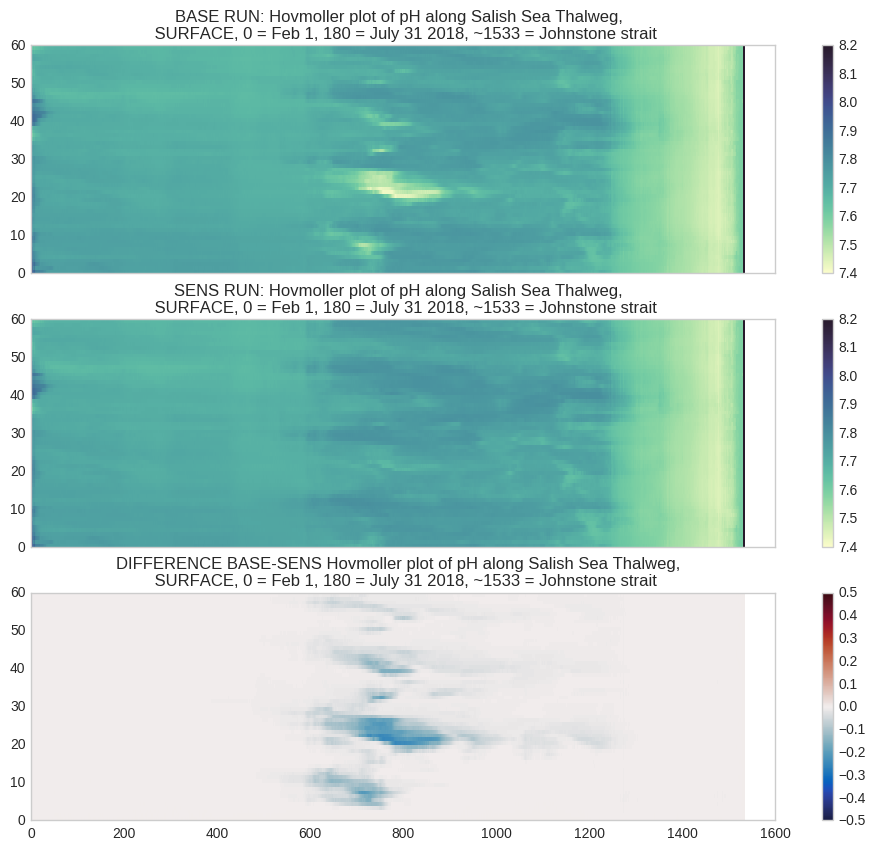

In [45]:
%matplotlib inline
vmin_p = 7.4
vmax_p = 8.2
###figures
fig = plt.figure(figsize=(12,10))

for i in range(1,4):
    if i == 1:
        ax = fig.add_subplot(3,1,i)
        tplt = pHr_b
        t_cmap = cm.cm.deep
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=vmin_p, vmax=vmax_p)
        ax.set_title('BASE RUN: Hovmoller plot of pH along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(3,1,i)
        tplt = pHr_s
        t_cmap = cm.cm.deep
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=vmin_p, vmax=vmax_p)
        ax.set_title('SENS RUN: Hovmoller plot of pH along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(3,1,i)
        tplt = pHr_b - pHr_s 
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-0.5, vmax=0.5)
        ax.set_title('DIFFERENCE BASE-SENS Hovmoller plot of pH along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

        cbar = fig.colorbar(mesh, ax=ax)

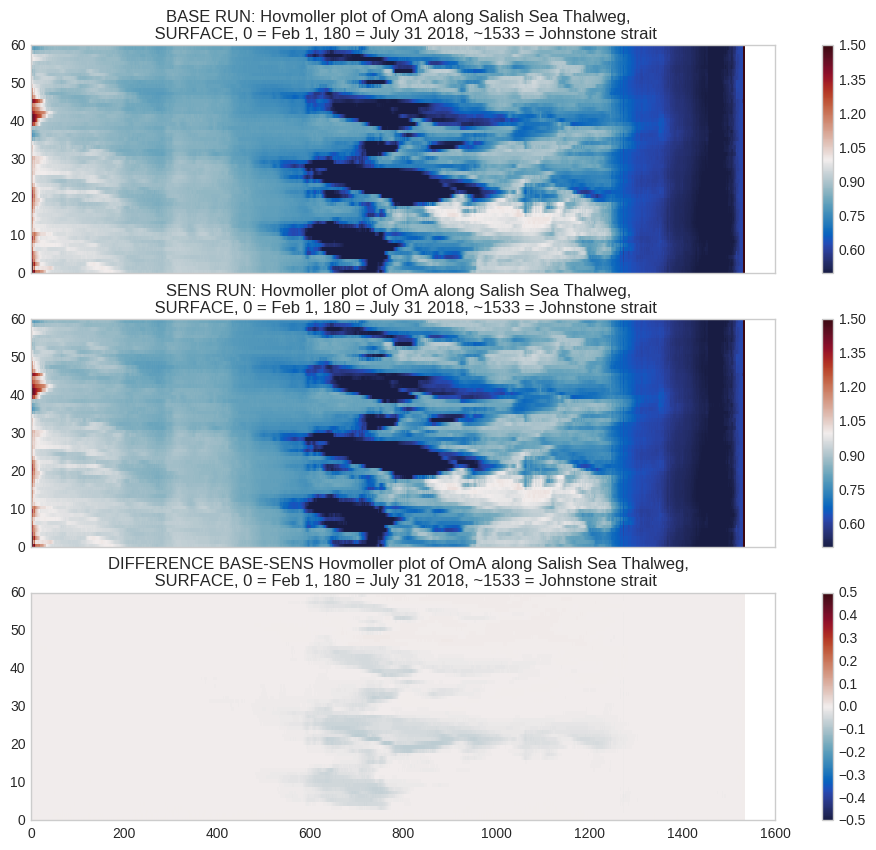

In [46]:
%matplotlib inline
vmin_p = 0.5
vmax_p = 1.5
###figures
fig = plt.figure(figsize=(12,10))

for i in range(1,4):
    if i == 1:
        ax = fig.add_subplot(3,1,i)
        tplt = OmAr_b
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=vmin_p, vmax=vmax_p)
        ax.set_title('BASE RUN: Hovmoller plot of OmA along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(3,1,i)
        tplt = OmAr_s
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=vmin_p, vmax=vmax_p)
        ax.set_title('SENS RUN: Hovmoller plot of OmA along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(3,1,i)
        tplt = OmAr_b - OmAr_s 
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-0.5, vmax=0.5)
        ax.set_title('DIFFERENCE BASE-SENS Hovmoller plot of OmA along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

        cbar = fig.colorbar(mesh, ax=ax)

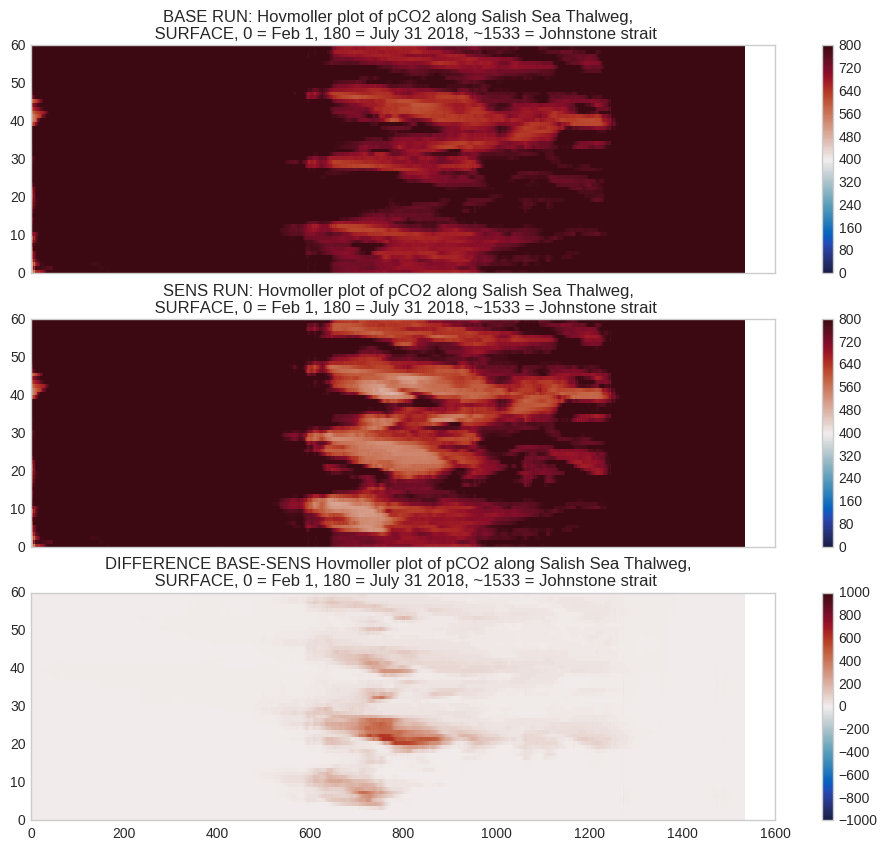

In [47]:
%matplotlib inline
vmin_p = 0
vmax_p = 800
###figures
fig = plt.figure(figsize=(12,10))

for i in range(1,4):
    if i == 1:
        ax = fig.add_subplot(3,1,i)
        tplt1 = pco2r_b
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt1, cmap=t_cmap, vmin=vmin_p, vmax=vmax_p)
        ax.set_title('BASE RUN: Hovmoller plot of pCO2 along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(3,1,i)
        tplt2 = pco2r_s
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt2, cmap=t_cmap, vmin=vmin_p, vmax=vmax_p)
        ax.set_title('SENS RUN: Hovmoller plot of pCO2 along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')
        cbar = fig.colorbar(mesh, ax=ax)
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(3,1,i)
        tplt = tplt1 - tplt2
        t_cmap = cm.cm.balance
        mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=-1000, vmax=1000)
        ax.set_title('DIFFERENCE BASE-SENS Hovmoller plot of pCO2 along Salish Sea Thalweg,  \n SURFACE, 0 = Feb 1, 180 = July 31 2018, ~1533 = Johnstone strait')

        cbar = fig.colorbar(mesh, ax=ax)

In [4]:
import netCDF4 as nc
w = nc.Dataset('/data/tjarniko/results/SAMPL/SalishSea_1ts_20141121_20141121_carp_T_20141121-20141121.nc')

print(w)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SalishSea_1ts_20141121_20141121
    description: auxilary variables
    title: auxilary variables
    Conventions: CF-1.6
    timeStamp: 2019-Feb-13 20:56:06 GMT
    uuid: d00cd20b-90c4-4bb4-988e-cff95312adb2
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(4)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 PAR(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 sigma_theta(time_counter,deptht,y,x), float32 e3t(time_counter,deptht,y,x), float32 dissolved_inorganic_carbon(time_counter,deptht,y,x), float3